In [2]:
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
import pandas as pd

Using TensorFlow backend.
c:\users\shank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
# Define dataset path and extract labels
path = "Dataset"
labels = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
print(labels)   

['Melanoma', 'NotMelanoma']


In [4]:
# Function to get integer label from given label
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [5]:
# Load VGG19 model
base_model = VGG19(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Load or process dataset
if os.path.exists("model/X_vgg19.npy") and os.path.exists("model/Y_vgg19.npy"):
    X = np.load('model/X_vgg19.npy')
    Y = np.load('model/Y_vgg19.npy')
else:  
    X = []
    Y = []
    for root, dirs, directory in os.walk(path): 
        for j in range(len(directory)): 
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root + "/" + directory[j])
                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                features = model.predict(img)
                features = np.squeeze(features)
                X.append(features)
                label = getLabel(name)
                Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X_vgg19.npy', X)
    np.save('model/Y_vgg19.npy', Y)

print("Dataset images loaded")
print("Total images found in dataset : " + str(X.shape[0]))


Dataset images loaded
Total images found in dataset : 2169


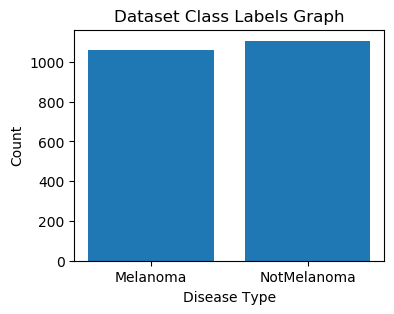

In [6]:
# Plot class labels count graph
unique, count = np.unique(Y, return_counts=True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize=(4,3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.title("Dataset Class Labels Graph")
plt.show()


In [7]:
# Preprocess images like shuffling and normalization
X = X.astype('float32')
X = X / 255  # Normalize pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)  # Shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : " + str(X_train.shape[0]))
print("20% images used to test algorithms : " + str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 1735
20% images used to test algorithms : 434


In [8]:
# Define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

# Function to calculate metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test, predict) * 100
    p = precision_score(y_test, predict, average='macro') * 100
    r = recall_score(y_test, predict, average='macro') * 100
    f = f1_score(y_test, predict, average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(f"{algorithm} Accuracy  : {a}")
    print(f"{algorithm} Precision : {p}")
    print(f"{algorithm} Recall    : {r}")
    print(f"{algorithm} FScore    : {f}")    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis", fmt ="g")
    ax.set_ylim([0, len(labels)])
    plt.title(f"{algorithm} Confusion Matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


In [9]:
X_train1 = X_train.reshape((X_train.shape[0], -1))
X_test1 = X_test.reshape((X_test.shape[0], -1))
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)

XGBoost Classifier Accuracy  : 94.93087557603687
XGBoost Classifier Precision : 94.92699721590547
XGBoost Classifier Recall    : 94.92699721590547
XGBoost Classifier FScore    : 94.92699721590547


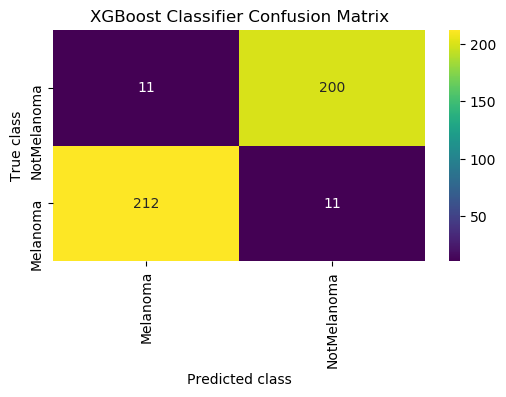

In [10]:
xgb_cls = xgb.XGBClassifier()
xgb_cls.fit(X_train1, y_train1)
predict = xgb_cls.predict(X_test1)
calculateMetrics("XGBoost Classifier", predict, y_test1)

[LightGBM] [Info] Number of positive: 896, number of negative: 839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.062942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1425613
[LightGBM] [Info] Number of data points in the train set: 1735, number of used features: 19569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516427 -> initscore=0.065730
[LightGBM] [Info] Start training from score 0.065730
LightGBM Classifier Accuracy  : 94.93087557603687
LightGBM Classifier Precision : 94.92065515263526
LightGBM Classifier Recall    : 94.93974879391325
LightGBM Classifier FScore    : 94.92818289988101


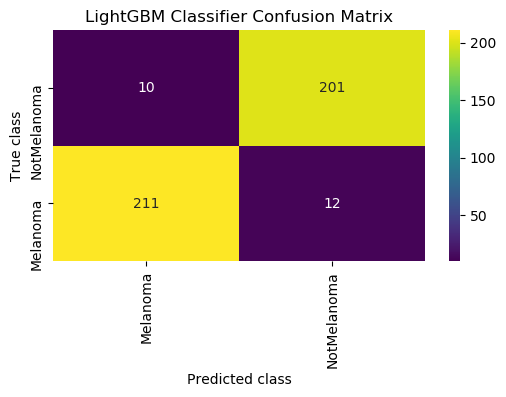

In [11]:
# Train LightGBM algorithm
lgb_cls = lgb.LGBMClassifier()
lgb_cls.fit(X_train1, y_train1)
predict = lgb_cls.predict(X_test1)
calculateMetrics("LightGBM Classifier", predict, y_test1)

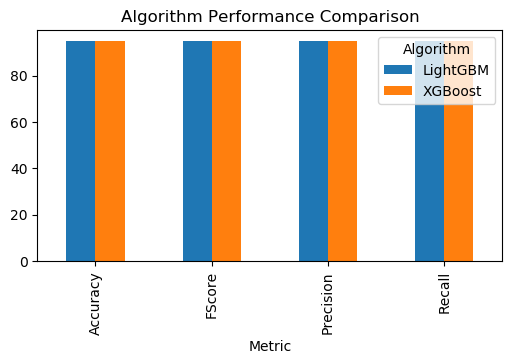

In [12]:
# Plot all algorithm performance
df = pd.DataFrame([
   
    ['XGBoost', 'Accuracy', accuracy[0]], ['XGBoost', 'Precision', precision[0]], ['XGBoost', 'Recall', recall[0]], ['XGBoost', 'FScore', fscore[0]],
    ['LightGBM', 'Accuracy', accuracy[1]], ['LightGBM', 'Precision', precision[1]], ['LightGBM', 'Recall', recall[1]], ['LightGBM', 'FScore', fscore[1]],
], columns=['Algorithm', 'Metric', 'Value'])
df.pivot("Metric", "Algorithm", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("Algorithm Performance Comparison")
plt.show()

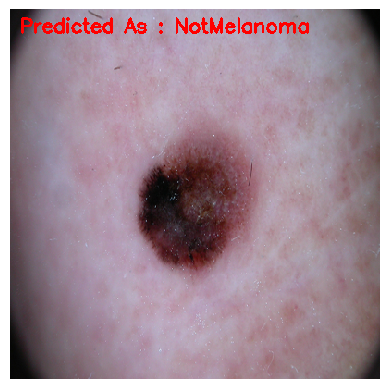

In [13]:
# Prediction function using LightGBM
def predict(image_path):
    # Load VGG19 model
    base_model = VGG19(weights='imagenet', include_top=False)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    # Extract features using VGG19
    features = model.predict(img)
    features = np.squeeze(features)
    
    # Flatten the features and normalize
    features = features.flatten().reshape(1, -1)
    features = features / 255.0
    
    # Predict using LightGBM
    predict = lgb_cls.predict(features)
    
    # Display the image with prediction
    img_display = cv2.imread(image_path)
    img_display = cv2.resize(img_display, (400, 400))
    cv2.putText(img_display, 'Predicted As : ' + labels[int(predict)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Call this function to predict
predict("testImages/1.jpg")

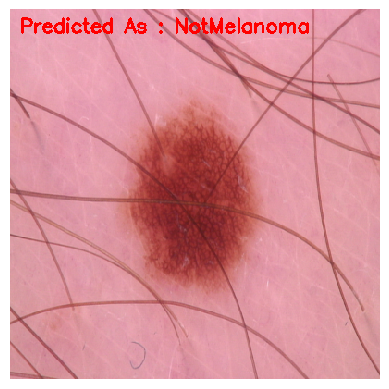

In [14]:
# Call this function to predict
predict("testImages/7.jpg")

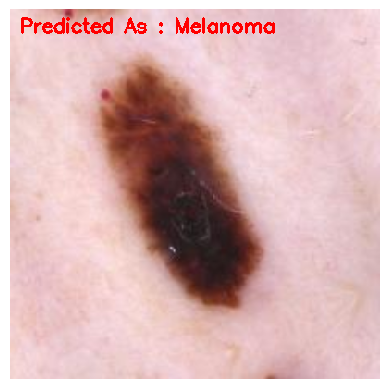

In [15]:
# Call this function to predict
predict("testImages/2.jpeg")

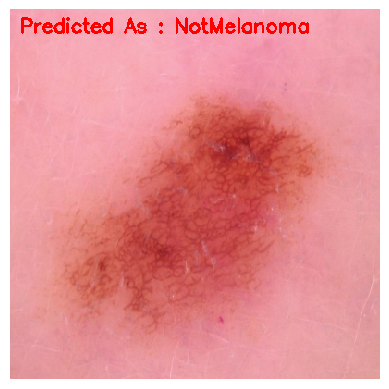

In [16]:
# Call this function to predict
predict("testImages/6.jpg")

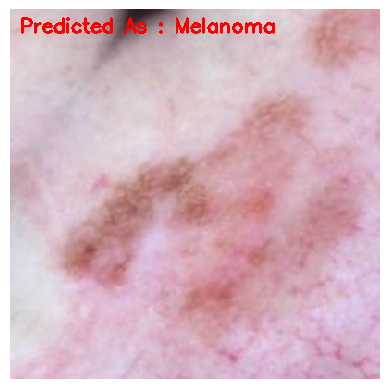

In [17]:
# Call this function to predict
predict("Dataset\Melanoma\AUG_0_14.jpeg")